In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import seaborn as sb
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer 
from sklearn.discriminant_analysis import StandardScaler 
from sklearn.preprocessing import QuantileTransformer 

In [2]:
import warnings

# Suppressing specific warning
warnings.filterwarnings("ignore", category=FutureWarning)

# Suppressing all warnings
warnings.filterwarnings("ignore")


In [3]:
file_path= r"C:\Users\subha\Desktop\AgriSage\Data\Crop_Recommendation.csv"
raw_data= pd.read_csv (file_path)

In [4]:
features= raw_data.columns[:-1]
features

Index(['Nitrogen', 'Phosphorus', 'Potassium', 'Temperature', 'Humidity',
       'pH_Value', 'Rainfall'],
      dtype='object')

In [5]:
target = 'Crop'

Encoding is a crucial step in preparing data for machine learning models, particularly when dealing with categorical or text data. Encoding allows ud to reduce complexity, capture relationships and patterns, ensure consistency and also enhances model interpretability. Here, we compare two popular encoding techniques and compare them to finalize our model. The encoding techniques used are:
1. Label Encoding
2. One-Hot Encoding

## Label Encoding

In [6]:
def transform_data_le(df, target, num_features):
    # Ensure num_features is a list
    if isinstance(num_features, pd.Index):
        num_features = num_features.tolist()

    # Encoding target
    lbl_encoder = LabelEncoder()
    df[target+'_Encoded'] = lbl_encoder.fit_transform(df[target])
    
    # Assigning features and labels
    x = df.drop([target, target+'_Encoded'], axis=1)
    y = df[target+'_Encoded']
    
    # Splitting the dataset into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=101)
    
    # Accessing the encoded classes
    encoded_classes = lbl_encoder.classes_
    # Printing the mapping (index corresponds to encoded value, value is the original label)
    for i, label in enumerate(encoded_classes):
        print(f"Encoded Value: {i}, Original Label: {label}")    
    
    # Standardization and Encoding
    # Define transformers for different column types
    std_scaler = StandardScaler()
    quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)

    # Combine transformers for specific columns
    preprocessor = ColumnTransformer([
        ("num", std_scaler, num_features),
        ("num_trns", quantile_transformer, num_features)
    ])
     # Fit transformers on training data only
    preprocessor.fit(x_train)

    # Transform train and test data using fitted transformers
    x_train_transformed = preprocessor.transform(x_train)
    x_test_transformed = preprocessor.transform(x_test)
    
    return x_train_transformed, x_test_transformed, y_train, y_test

In [7]:
x_train, x_test, y_train, y_test = transform_data_le(raw_data, target, features)

Encoded Value: 0, Original Label: Apple
Encoded Value: 1, Original Label: Banana
Encoded Value: 2, Original Label: Blackgram
Encoded Value: 3, Original Label: ChickPea
Encoded Value: 4, Original Label: Coconut
Encoded Value: 5, Original Label: Coffee
Encoded Value: 6, Original Label: Cotton
Encoded Value: 7, Original Label: Grapes
Encoded Value: 8, Original Label: Jute
Encoded Value: 9, Original Label: KidneyBeans
Encoded Value: 10, Original Label: Lentil
Encoded Value: 11, Original Label: Maize
Encoded Value: 12, Original Label: Mango
Encoded Value: 13, Original Label: MothBeans
Encoded Value: 14, Original Label: MungBean
Encoded Value: 15, Original Label: Muskmelon
Encoded Value: 16, Original Label: Orange
Encoded Value: 17, Original Label: Papaya
Encoded Value: 18, Original Label: PigeonPeas
Encoded Value: 19, Original Label: Pomegranate
Encoded Value: 20, Original Label: Rice
Encoded Value: 21, Original Label: Watermelon


## One-Hot Encoding

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, QuantileTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

def transform_data_ohe(df, target, num_features):
    # Ensure num_features is a list
    if isinstance(num_features, pd.Index):
        num_features = num_features.tolist()
        
    # Encoding target
    onehot_encoder = OneHotEncoder(sparse_output=False)
    target_encoded = onehot_encoder.fit_transform(df[[target]])
    
    # Creating a DataFrame with encoded target columns
    target_encoded_df = pd.DataFrame(target_encoded, columns=[f"{target}_{cat}" for cat in onehot_encoder.categories_[0]])
    
    # Concatenate the original DataFrame with the new one-hot encoded target columns
    df = pd.concat([df.drop(target, axis=1), target_encoded_df], axis=1)
    
    # Assigning features and labels
    x = df.drop(target_encoded_df.columns, axis=1)
    y = df[target]  # Use original target column for labels
    
    # Splitting the dataset into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=101)
    
    # Standardization and Encoding
    # Define transformers for different column types
    std_scaler = StandardScaler()
    quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)

    # Combine transformers for specific columns
    preprocessor = ColumnTransformer([
        ("num_std", std_scaler, num_features),
        #("num_quantile", quantile_transformer, num_features) # Uncomment this line if you really want Quantile transformation instead of or in addition to standard scaling
    ])
    
    # Fit transformers on training data only
    preprocessor.fit(x_train)

    # Transform train and test data using fitted transformers
    x_train_transformed = preprocessor.transform(x_train)
    x_test_transformed = preprocessor.transform(x_test)
    
    return x_train_transformed, x_test_transformed, y_train.values.ravel(), y_test.values.ravel()


In [11]:
x_train, x_test, y_train, y_test= transform_data_ohe(raw_data, target, features)

KeyError: 'Crop'

In [8]:
y_train.head()

524     13
2159     5
645     14
520     13
1328    21
Name: Crop_Encoded, dtype: int32

## model

In [16]:
from sklearn.model_selection import StratifiedKFold, cross_validate


def model_comparison(x, y, models):
    names = []
    scoring = ['accuracy']
    
    # Create a dataframe to store the different metric values for each algorithm
    df_results = pd.DataFrame(columns=['Algorithm', 'Acc Mean', 'Acc STD'])
    results_acc = [] # List of accuracy scores for each fold of each algorithm
    
    for name, model in models:
        names.append(name)
        kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=101)
        result = cross_validate(model, x, y, cv=kfold, scoring=scoring)
        # Mean and standard deviation of Accuracy scores for the algorithm
        acc_mean = result['test_accuracy'].mean()
        acc_std = result['test_accuracy'].std()
        
        # Create the row of the results
        df_result_row = {'Algorithm': name, 'Acc Mean': acc_mean, 'Acc STD': acc_std}
        # Add the row to the results data frame
        df_results = pd.concat([df_results, pd.DataFrame([df_result_row])], ignore_index=True)
        
        results_acc.append(result['test_accuracy'])

    df_results = df_results.set_index('Algorithm')
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    # Display the mean and standard deviation of all metrics for all algorithms
    print(df_results) 
    # Convert the results_acc dictionary into a DataFrame for plotting
    results_acc_df = pd.DataFrame(results_acc).T
    print(f"results_acc_df: {results_acc_df}")
    # Create a box plot for the accuracy results
    plt.figure(figsize=(12, 8))
    ax = sb.boxplot(data=results_acc_df)
    ax.set_title('Model Comparison - Accuracy Scores')
    ax.set_xlabel('Algorithm')
    ax.set_ylabel('Accuracy')
    ax.set_xticklabels(names) 
    plt.show()

In [27]:
from sklearn.model_selection import StratifiedKFold, cross_validate


def model_comparison_withstats(x, y, models, stats):
    names = []
    scoring = ['accuracy']
    
    # Create a dataframe to store the different metric values for each algorithm
    df_results = pd.DataFrame(columns=['Algorithm', 'Acc Mean', 'Acc STD'])
    results_acc = [] # List of accuracy scores for each fold of each algorithm
    
    for name, model in models:
        names.append(name)
        kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=101)
        result = cross_validate(model, x, y, cv=kfold, scoring=scoring)
        # Mean and standard deviation of Accuracy scores for the algorithm
        acc_mean = result['test_accuracy'].mean()
        acc_std = result['test_accuracy'].std()
        
        # Create the row of the results
        df_result_row = {'Algorithm': name, 'Acc Mean': acc_mean, 'Acc STD': acc_std}
        # Add the row to the results data frame
        df_results = pd.concat([df_results, pd.DataFrame([df_result_row])], ignore_index=True)
        
        results_acc.append(result['test_accuracy'])

    # Add the means and standard deviations of the encoded variables to the results dataframe
    for feature, stat in stats.items():
        df_results[f'{feature} Mean Before'] = stat['mean_before']
        df_results[f'{feature} STD Before'] = stat['std_before']
        df_results[f'{feature} Mean After'] = stat['mean_after']
        df_results[f'{feature} STD After'] = stat['std_after']
        
    df_results = df_results.set_index('Algorithm')
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    # Display the mean and standard deviation of all metrics for all algorithms
    print(df_results)
    

In [10]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier


ens_models = []
ens_models.append(('RFC', RandomForestClassifier()))
ens_models.append(('ABC', AdaBoostClassifier()))
ens_models.append(('GBC', GradientBoostingClassifier()))

In [17]:
model_comparison_withstats(x_train, y_train, ens_models,stats)

NameError: name 'model_comparison_withstats' is not defined

in the above section, we understand that qfter quantile transformation and comparison of three models we get the above data. the mean and standard deviation after quantile transformation being 0 and 1 respevtively prove that the results are correct and the graph looks like a normal graph. this also matches our graph outputs during eda and data processing.

## model comparison

           Acc Mean  Acc STD
Algorithm                   
RFC           0.994    0.005
ABC           0.177    0.014
GBC           0.988    0.009
results_acc_df:       0     1     2
0 0.989 0.182 0.972
1 0.994 0.182 0.989
2 1.000 0.182 0.989
3 0.994 0.182 0.989
4 1.000 0.136 1.000
5 0.989 0.182 0.989
6 0.989 0.182 0.977
7 1.000 0.182 1.000
8 0.989 0.176 0.994
9 0.994 0.182 0.983


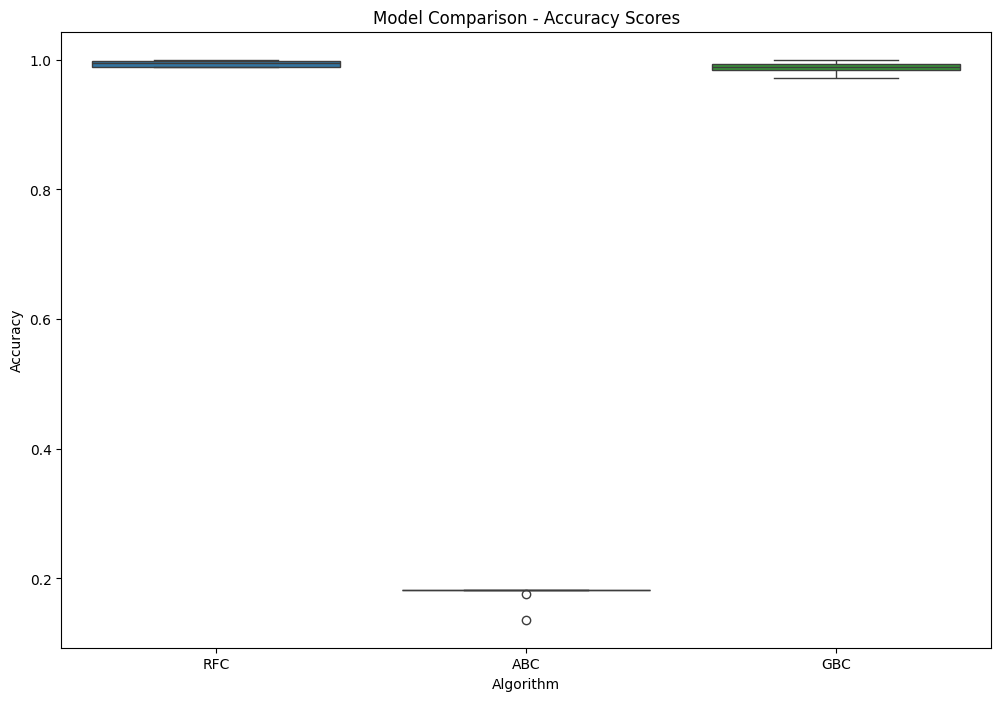

In [19]:
model_comparison(x_train, y_train, ens_models)

In [8]:
from sklearn.linear_model import SGDClassifier,  LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


new_models = []
new_models.append(('LR', LogisticRegression())) 
new_models.append(('SVC', SVC()))
new_models.append(('DTC', DecisionTreeClassifier()))
new_models.append(('KNN', KNeighborsClassifier()))
new_models.append(('GNB', GaussianNB()))
new_models.append(('XGB', SGDClassifier()))

           Acc Mean  Acc STD
Algorithm                   
LR            0.976    0.012
SVC           0.982    0.014
DTC           0.986    0.013
KNN           0.972    0.013
GNB           0.994    0.005
XGB           0.939    0.017
results_acc_df:       0     1     2     3     4     5
0 0.972 0.983 0.977 0.966 0.994 0.909
1 0.989 0.989 0.994 0.972 0.989 0.955
2 0.989 1.000 0.994 0.994 1.000 0.955
3 0.994 0.983 0.983 0.972 0.994 0.949
4 0.983 0.989 0.994 0.972 1.000 0.949
5 0.966 1.000 1.000 0.983 0.989 0.926
6 0.960 0.983 0.983 0.983 0.994 0.949
7 0.972 0.972 1.000 0.972 1.000 0.949
8 0.977 0.972 0.955 0.955 0.989 0.909
9 0.960 0.949 0.977 0.949 0.989 0.938


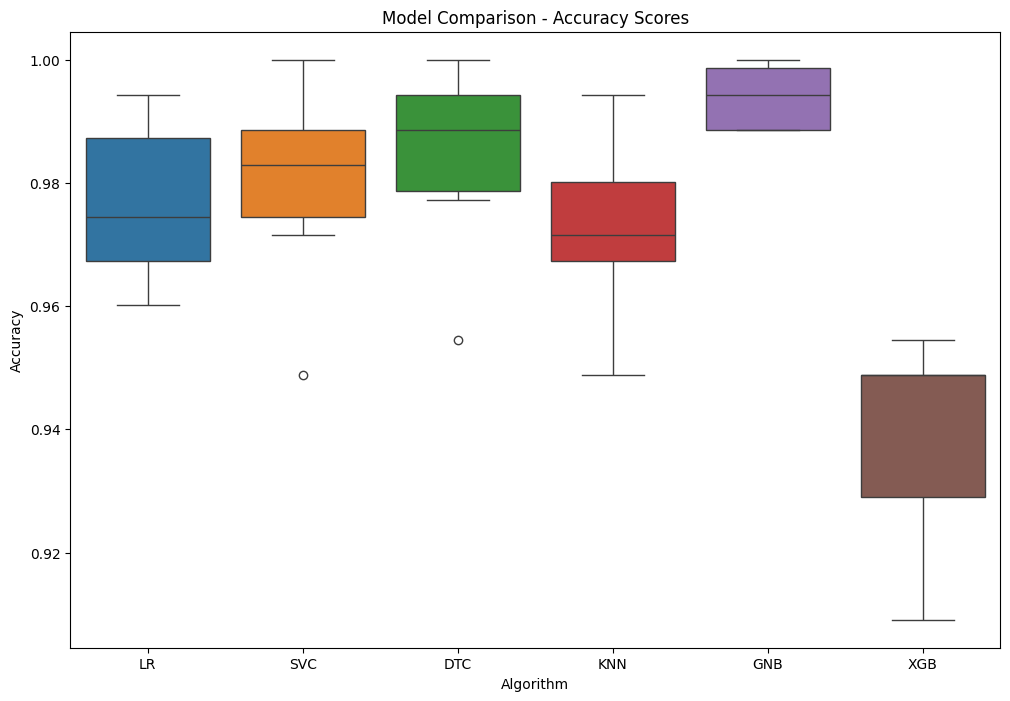

In [33]:

model_comparison(x_train, y_train, new_models)

In [20]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [21]:
y_hat = model.predict(x_test)

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [23]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        20
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        20
          11       1.00      1.00      1.00        20
          12       1.00      1.00      1.00        20
          13       1.00      1.00      1.00        20
          14       1.00      1.00      1.00        20
          15       1.00      1.00      1.00        20
          16       1.00      1.00      1.00        20
          17       1.00    

In [24]:
def plot_confusion_matrix(y_test, predictions):
    # Plot the confusion matrix
    cf_matrix = confusion_matrix(y_test, predictions)
    fig = plt.subplots(figsize=(10, 8))
    sb.set(font_scale=1.4)
    sb.heatmap(cf_matrix, annot=True, fmt='d')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
    
    # Reset font scale to default
    sb.set(font_scale=1)

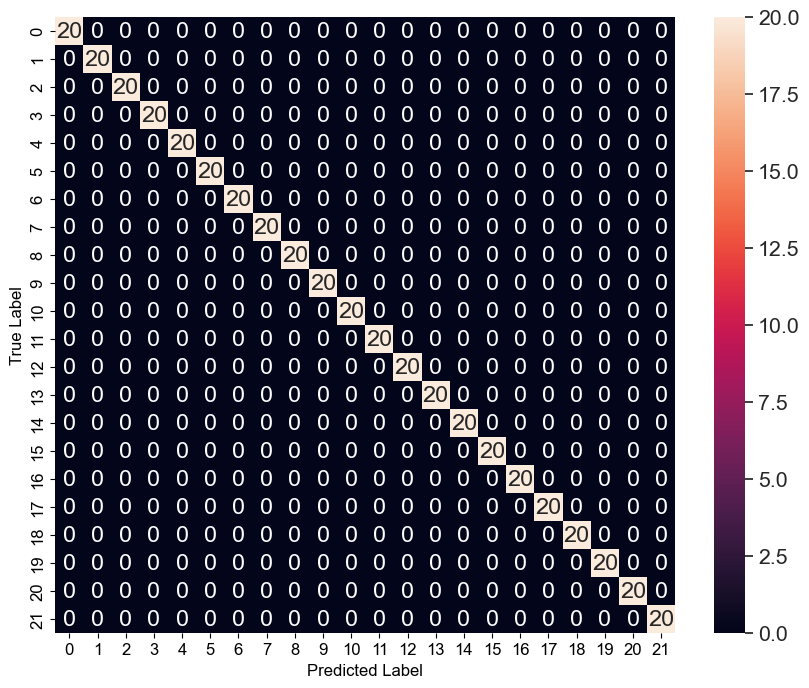

In [25]:
plot_confusion_matrix(y_test, y_hat)